<a href="https://www.kaggle.com/code/sayedshaun/crop-diseases-classification?scriptVersionId=168081432" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.color_palette('dark') 
import warnings
warnings.filterwarnings("ignore")
import torch
from torch import nn, Tensor
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from PIL import Image
!pip install torchsummary
from torchsummary import summary
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
df = pd.read_csv("/kaggle/input/crop-diseases-classification/Data/train.csv")
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [3]:
df.shape

(21397, 2)

In [4]:
with open("/kaggle/input/crop-diseases-classification/Data/label_num_to_disease_map.json", "r") as file:
    label_name = json.load(file)
label_name

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [5]:
image_path = "/kaggle/input/crop-diseases-classification/Data/train_images"
image_list = os.listdir(image_path)
df = df[df["image_id"].isin(image_list)]
df.reset_index(drop=True, inplace=True)
df.shape

(17938, 2)

In [6]:
path_name = "/kaggle/input/crop-diseases-classification/Data/train_images/"
df["image_path"] = df["image_id"].apply(lambda x: str(path_name+x))
df["label_name"] = df["label"].apply(lambda x: label_name[str(x)])
df.head()

,image_id,label,image_path,label_name
0,157078263.jpg,3,/kaggle/input/crop-diseases-classification/Dat...,Cassava Mosaic Disease (CMD)
1,1574893536.jpg,3,/kaggle/input/crop-diseases-classification/Dat...,Cassava Mosaic Disease (CMD)
2,1575013487.jpg,3,/kaggle/input/crop-diseases-classification/Dat...,Cassava Mosaic Disease (CMD)
3,1576606254.jpg,0,/kaggle/input/crop-diseases-classification/Dat...,Cassava Bacterial Blight (CBB)
4,1579761476.jpg,1,/kaggle/input/crop-diseases-classification/Dat...,Cassava Brown Streak Disease (CBSD)


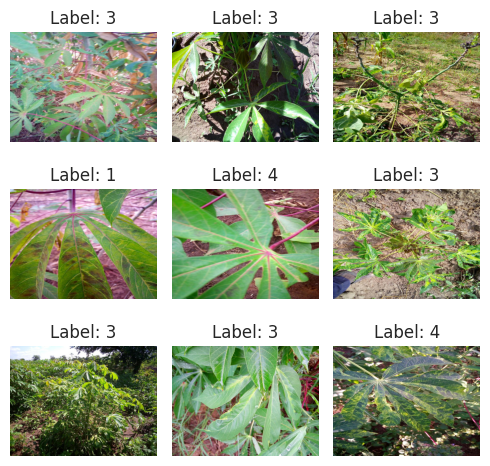

In [7]:
plot_images = df["image_path"].sample(9)
labels = df.loc[df["image_path"].isin(plot_images), "label"]

plt.figure(figsize=(5, 5))
for i, image_path in enumerate(plot_images):
    image = Image.open(image_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title(f"Label: {labels.iloc[i]}") 
    plt.axis('off') 

plt.tight_layout()
plt.show()

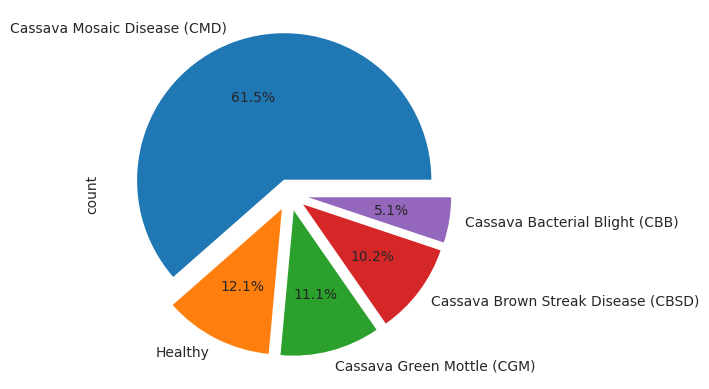

In [8]:
label_counts = df["label_name"].value_counts()
label_counts.plot(kind="pie", autopct='%1.1f%%', explode=[0.1]*len(label_counts))
plt.show()

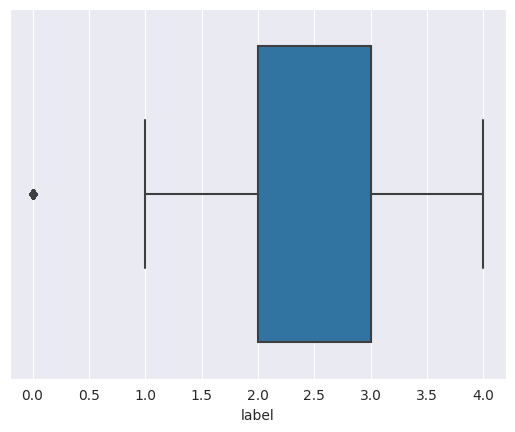

In [9]:
sns.boxplot(x=df["label"])
plt.show()

In [10]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.images = dataframe["image_path"]
        self.labels = dataframe["label"]
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        image = Image.open(image).convert("RGB").resize((224, 224))
        label = self.labels[index]
        return self.transform(image), label

dataset = CustomDataset(df)
dataloader = DataLoader(dataset, batch_size=64)

In [11]:
class MyCNN(nn.Module):
    def __init__(self, hidden_size:int, kernel_size:int)->None:
        super(MyCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, hidden_size, kernel_size),
            nn.MaxPool2d(kernel_size, kernel_size),
            nn.Conv2d(hidden_size, hidden_size, kernel_size),
            nn.MaxPool2d(kernel_size, kernel_size),
            nn.Conv2d(hidden_size, hidden_size, kernel_size),
            nn.MaxPool2d(kernel_size, kernel_size)
        )
        self.linear = nn.Linear(hidden_size * 7 * 7, hidden_size)
        self.classification = nn.Linear(hidden_size, 5)
        self.dropout = nn.Dropout()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()

    def forward(self, image_tensor:Tensor)->Tensor:
        x = self.conv_block(image_tensor)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.linear(self.relu(x))
        x = self.dropout(x)
        x = self.classification(x)
        return x
    
model = MyCNN(hidden_size=256, kernel_size=3).to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 222, 222]           7,168
         MaxPool2d-2          [-1, 256, 74, 74]               0
            Conv2d-3          [-1, 256, 72, 72]         590,080
         MaxPool2d-4          [-1, 256, 24, 24]               0
            Conv2d-5          [-1, 256, 22, 22]         590,080
         MaxPool2d-6            [-1, 256, 7, 7]               0
           Dropout-7            [-1, 256, 7, 7]               0
              ReLU-8            [-1, 256, 7, 7]               0
           Flatten-9                [-1, 12544]               0
             ReLU-10                [-1, 12544]               0
           Linear-11                  [-1, 256]       3,211,520
          Dropout-12                  [-1, 256]               0
           Linear-13                    [-1, 5]           1,285
Total params: 4,400,133
Trainable param

In [12]:
def train(model, loss_fn, optimizer, dataloader):
    loss_container = []
    model.train()
    epoch_loss = 0.0
    for batch, (features, labels) in enumerate(dataloader):
        features = features.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        pred = model(features)
        loss = loss_fn(pred, labels)

        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
    
    avg_loss = epoch_loss/len(dataloader)
    return avg_loss

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss = []
for epoch in tqdm(range(10)):
    t_loss = train(model, loss_fn, optimizer, dataloader)
    print(f"Training Loss: {t_loss:.3f}")
    train_loss.append(t_loss)

 10%|█         | 1/10 [06:41<1:00:16, 401.84s/it]

Training Loss: 1.176


 20%|██        | 2/10 [10:52<41:41, 312.67s/it]  

Training Loss: 1.044


 30%|███       | 3/10 [15:02<33:08, 284.06s/it]

Training Loss: 1.031


 40%|████      | 4/10 [19:10<26:59, 269.92s/it]

Training Loss: 0.994


 50%|█████     | 5/10 [23:17<21:48, 261.66s/it]

Training Loss: 0.963


 60%|██████    | 6/10 [27:26<17:09, 257.44s/it]

Training Loss: 0.944


 70%|███████   | 7/10 [31:34<12:42, 254.31s/it]

Training Loss: 0.928


 80%|████████  | 8/10 [35:42<08:24, 252.21s/it]

Training Loss: 0.926


 90%|█████████ | 9/10 [39:51<04:11, 251.40s/it]

Training Loss: 0.905


100%|██████████| 10/10 [44:01<00:00, 264.16s/it]

Training Loss: 0.888


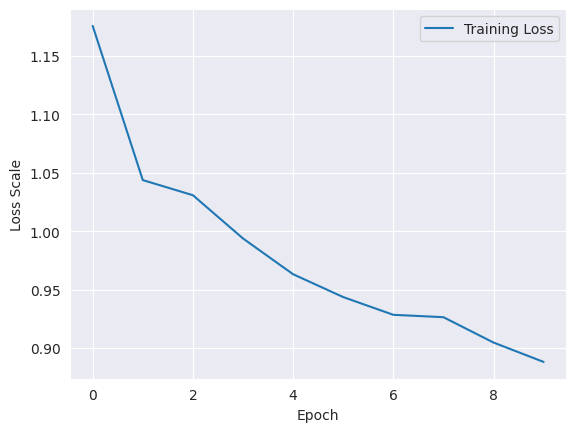

In [14]:
plt.plot(train_loss, label="Training Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss Scale')
plt.legend()
plt.show()